In [2]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8)

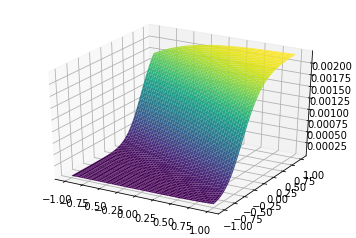

In [3]:
def fn(X,y,w):
  a = np.divide(1,(1+np.power(np.e,np.dot(X,w))))
  y = np.ones(100*100).reshape(1,-1)

  cost = 1/(2*225) * np.square(y-a)
  return cost

X,y = np.array([[2,4]]),np.array([1])
w1 = np.linspace(-1,1,100)
w2 = np.linspace(-1,1,100)

w1_,w2_ = np.meshgrid(w1,w2)
w = np.r_[[w1_.ravel()],[w2_.ravel()]]

cost = fn(X,y,w).reshape(w1_.shape)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(w1_,w2_,cost,cmap='viridis')

In [4]:
def plot_decision_boundary(X,y,clf):
  x_min,x_max = X[:,0].min()-1,X[:,0].max() + 1
  y_min, y_max  = X[:,1].min() -1 , X[:,1].max() +1
  distance = 0.01

  xx,yy = np.meshgrid(np.arange(x_min,x_max,distance),np.arange(y_min,y_max,distance))
  Z = clf(np.c_[xx.ravel(),yy.ravel()])
  Z = Z.reshape(xx.shape)
  
  plt.contourf(xx,yy,Z,cmap=plt.cm.Spectral)
  plt.scatter(X[:,0], X[:,1],c=y,cmap='viridis')

In [5]:
X,y = make_moons(800,noise=0.15,shuffle=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True)

In [6]:
[X_train.shape,y_train.shape]

[(600, 2), (600,)]

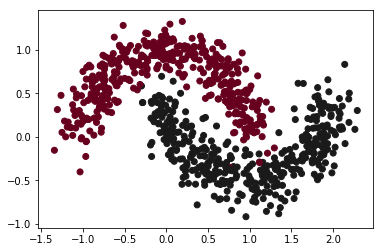

In [7]:
plt.scatter(X[:,0],X[:,1],c=y,cmap='RdGy')

In [8]:
logistic_regression = MLPClassifier((25,),activation='relu',max_iter = 1000)

In [9]:
logistic_regression.fit(X,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(25,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

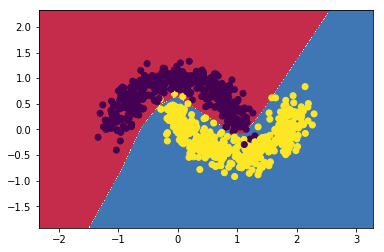

In [10]:
plot_decision_boundary(X,y,lambda x : logistic_regression.predict(x))

## `Building the net`

In [11]:
def build_network(input_size,output_size,hidden_layers):
  
  weight_dict = {}
  bias_dict = {}
  
  L = len(hidden_layers)+2
  
  n = input_size[1]
  y_size = output_size[1]
  
  weight_dict['12'] = np.random.randn(n,hidden_layers[0]) * 0.01
  bias_dict['12'] = np.zeros((1,hidden_layers[0]))
    
  weight_dict[str(L-1)+str(L)] = np.random.randn(hidden_layers[-1],y_size) * 0.01
  bias_dict[str(L-1)+str(L)] = np.zeros((1,y_size))

              
  for x in range(2,L-1):
    weight_dict[str(x)+str(x+1)] = np.random.randn(hidden_layers[x-2],hidden_layers[x-1]) * 0.01
    bias_dict[str(x)+str(x+1)] = np.zeros((1,hidden_layers[x-1]))
  
  return weight_dict,bias_dict,L


In [12]:
def relu(z):
  z[z<0] = 0
  return z

def sigmoid(z):
  return np.divide(1,(1+np.power(np.e,-z)))

def dsigmoid(a):
  return a * (1-a)

def drelu(a):
  a[a>0] = 1
  return a

In [13]:
def forward_pass(X,weight_dict,bias_dict,L):
  a = X
  activation_dict = {}
  dactivation_dict={}
  
  for layer in range(1,L):
    z = np.dot(a,weight_dict[str(layer)+str(layer+1)]) + bias_dict[str(layer)+str(layer+1)]
    if layer != L-1: 
      a = relu(z)
      dactivation_dict[str(layer+1)] = drelu(a)
      activation_dict[str(layer+1)] = a
    else:
      a = sigmoid(z)
      dactivation_dict[str(layer+1)] = dsigmoid(a)
      activation_dict[str(layer+1)] = a
  
  return a,activation_dict,dactivation_dict

In [14]:
def calculate_cost(y,a,weight_dict,m):
  #-1/n * (yln(a) + (1-y)(ln(1-a))) + sum(W^2) for all W

  cost = -1/m * (np.dot(y.T,np.log(a)) + np.dot((1-y).T,np.log(1-a)))
  reg_term = 0
  lambda_ = 0.01
  
#   for value in weight_dict.values():
#      reg_term+= np.sum(np.square(value))
#   cost+=(lambda_ * reg_term)
  return np.squeeze(cost)

In [15]:
def calc_layer_errors(y,op,dactivation_dict,L,weights_dict):
  error_dict = {}
  for layer in reversed(range(1,L)):
    if layer == L-1: 
      error_dict[str(layer+1)] = op-y.reshape(-1,1)
      continue
    
    error_dict[str(layer+1)] = np.dot(error_dict[str(layer+2)],weights_dict[str(layer+1)+str(layer+2)].T) * dactivation_dict[str(layer+1)]
  return error_dict

In [16]:
def calculate_gradients(activation_dict,error_dict,L,m):
  dW = {}
  dB = {}
  for layer in range(1,L):
    dW[str(layer)+str(layer+1)] = 1/m * np.dot(activation_dict[str(layer)].transpose(),error_dict[str(layer+1)])
    dB[str(layer) + str(layer+1)] = 1/m * np.sum(error_dict[str(layer+1)],axis=0,keepdims=True)
  return dW,dB

In [17]:
def update_weights(weights_dict,bias,dW,dB,learning_rate):
  updated_weights = {}
  updated_bias = {}
  for key in weights_dict.keys():
    updated_weights[key] = weights_dict[key] - learning_rate*dW[key]
    updated_bias[key] = bias[key] - learning_rate*dB[key]
  return updated_weights,updated_bias

In [18]:
def nn_model(X_train,Y_train,hidden_layers):
  #Build your network
  #Repeat for 100 iterations
    #Do a forward pass
    #Calculate cost
    #Calculate layer errors
    #Calculate gradients
    #Update Weights
  weights,bias,L = build_network(X_train.shape,y_train.reshape(-1,1).shape,hidden_layers)
  costs = []
  m = X_train.shape[0]

  for _ in range(10000):
    op,a_dict,da_dict = forward_pass(X_train,weights,bias,L)
    a_dict['1'] = X_train
    cost = calculate_cost(y_train,op,weights,m)
    #print(cost)
    costs.append(cost)
    error_dict = calc_layer_errors(y_train,op,da_dict,L,weights)
    dW,dB = calculate_gradients(a_dict,error_dict,L,m)
    weights,bias = update_weights(weights,bias,dW,dB,0.6)
    
  return weights,bias,L,costs

In [19]:
def predict(X_test,parameters):
  weights,bias,L,costs = parameters
  op,a_dict,da_dict = forward_pass(X_test,weights,bias,L)
  
  return op>0.5

In [39]:
weights,bias,L,costs = nn_model(X_train,y_train,[14])
parameters = [weights,bias,L,costs]

In [40]:
op = predict(X_test,parameters)

In [41]:
parameters[-1][-1]

array(0.34608564)

In [42]:
def accuracy(y,a):
  return np.squeeze(np.dot(y.T,a) + np.dot((1-y).T,(1-a))) / y.shape[0] *100

In [43]:
accuracy(y_test,op)

88.0

In [44]:
costs

[array(0.69752155),
 array(0.60034889),
 array(0.55618532),
 array(0.51039383),
 array(0.45438263),
 array(0.4586411),
 array(0.40935322),
 array(0.4339836),
 array(0.38511052),
 array(0.41806725),
 array(0.36684111),
 array(0.38513835),
 array(0.35354625),
 array(0.36420681),
 array(0.34713428),
 array(0.34393801),
 array(0.33812843),
 array(0.33330343),
 array(0.32993696),
 array(0.32831227),
 array(0.32473733),
 array(0.32416353),
 array(0.31829284),
 array(0.31876507),
 array(0.32034014),
 array(0.31685606),
 array(0.31387824),
 array(0.31388161),
 array(0.313429),
 array(0.30966486),
 array(0.30885027),
 array(0.30401806),
 array(0.30429837),
 array(0.30089419),
 array(0.30071446),
 array(0.29920357),
 array(0.29860603),
 array(0.29689001),
 array(0.29714065),
 array(0.29590707),
 array(0.29581595),
 array(0.29594168),
 array(0.29620647),
 array(0.29738909),
 array(0.29580192),
 array(0.2943592),
 array(0.29366914),
 array(0.29429256),
 array(0.29328669),
 array(0.29176),
 array(0

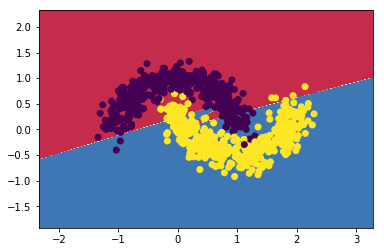

In [45]:
plot_decision_boundary(X,y,lambda x:predict(x,parameters))

In [26]:
X_new,y_new= make_moons(400,noise=0.2,shuffle=True)

In [27]:
op = predict(X_new,parameters)

In [28]:
accuracy(y_new,op)

88.25